# Likelihood Surface Construction

In [1]:

import os
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
#os.environ['XLA_FLAGS']='--xla_gpu_deterministic_ops=true --xla_gpu_autotune_level=0'
#os.environ['TF_DETERMINISTIC_OPS']='1'

import jax
import itertools
import numpy as onp
import ptitprince as pt

import jax.numpy as np
import ipywidgets as widgets
import pandas as pd

from jax.numpy.linalg import inv, pinv
from jax.scipy.optimize import minimize
from scipy.linalg import solve_discrete_are as dare
from jax import jit, grad
from IPython import display
from toolz.dicttoolz import valmap, itemmap
from itertools import chain
from functools import partial

from tqdm.notebook import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

from pomps import *
from resampling import *
from filtering import *
from optim import *


import matplotlib.pyplot as plt
plt.style.use('matplotlibrc')
onp.set_printoptions(suppress=True)

2024-08-26 17:28:06.127601: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset = pd.read_csv('data/dacca/dacca.csv', index_col=0).reset_index(drop=True)
ys = np.array(dataset['cholera.deaths'].values)
dataset = pd.read_csv('data/dacca/covars.csv', index_col=0).reset_index(drop=True)
dataset.index = pd.read_csv('data/dacca/covart.csv', index_col=0).reset_index(drop=True).squeeze()
dataset = dataset.reindex(onp.array([1891 + i*(1/240) for i in range(12037)])).interpolate()
covars = np.array(dataset.values)#[20:]
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, k, delta = 8.0, 9.238, 7.1, 0.7, onp.exp(-4.5), 0.0051, (-6.8*10**(-3)), 639.6, 0.23, np.array([6.5,11.4,2.1,9.0,8.6,9.5]), 3, 0.02
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, k, delta = 17.3, 0.057, 0, 9.8, onp.exp(-4.8), 0.999999, (-5.0*10**(-3)), 3.2, 0.25, np.array([1.2,6.2,-3.4,3.9,3.2,4.3]), 3, 0.02


gamma = 20.8
epsilon = 19.1
rho = 0
delta = 0.02
m = 0.06
c = np.array(1)
beta_trend = -0.00498
bs = np.array([0.747, 6.38, -3.44, 4.23, 3.33, 4.55])
sigma = 3.13 #3.13 # 0.77
tau = 0.23 
omega = onp.exp(-4.5)
omegas = np.log(np.array([0.184, 0.0786, 0.0584, 0.00917, 0.000208, 0.0124]))


theta = transform_thetas(gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas)

def resample_key(norm_weights, key):
    J = norm_weights.shape[-1]
    #counts = jax.random.categorical(key=jax.random.PRNGKey(randint), 
    #                   logits=jax.lax.stop_gradient(norm_weights),
    #                    shape=(J,))
    
    #unifs = 0.5+np.linspace(0,1,J)
    #unifs = np.where(unifs>=1, x=unifs-1, y=unifs) #when true x, else y
    
    #ARCHIVE
    #unifs = unifs.at[unifs>=1].set(unifs[unifs>=1]-1)
    
    unifs = (jax.random.uniform(key=key)+np.arange(J)) / J
    
    csum = np.cumsum(np.exp(norm_weights))
    counts = np.repeat(np.arange(J), 
                       np.histogram(unifs, 
                        bins=np.pad(csum/csum[-1], pad_width=(1,0)), 
                            density=False)[0].astype(int),
                      total_repeat_length=J)
    
    #if len(counts)<J:
    #    counts = np.hstack([counts, np.zeros(J-len(counts))]).astype(int)
    return counts

def resampler_key(counts, particlesP, norm_weights, key):
    J = norm_weights.shape[-1]
    counts = resample_key(norm_weights, key)
    particlesF = particlesP[counts]
    norm_weights = norm_weights[counts] - jax.lax.stop_gradient(norm_weights[counts]) - np.log(J)
    return counts, particlesF, norm_weights


def pfilter_debug_helper(t, inputs):
    particles, meas_particles, particlesF, theta, covars, loglik, norm_weights, counts, ys, thresh, key = inputs
    J = len(particlesF)
    key = jax.random.PRNGKey(0)
    
    key, *keys = jax.random.split(key, num=J+1)
    keys = np.array(keys)
        
    # Get prediction particles 
    particlesP = rprocess(particlesF, theta, keys, covars)# if t>0 else particlesF
        
    measurements = dmeasure(ys[t], particlesP, theta)
    
    # Multiply weights by measurement model result
    weights = norm_weights + measurements

    # Obtain normalized weights
    norm_weights, loglik_t = normalize_weights(weights)
    loglik += loglik_t
    
    meas_particles = meas_particles.at[t].set(measurements)
    
    counts, particlesF, norm_weights = resampler_key(counts, particlesP, norm_weights, key)

    #jax.debug.print(loglik, loglik_t)
    particles = particles.at[t+1].set(particlesF)
    return [particles, meas_particles, particlesF, theta, covars, loglik, norm_weights, counts, ys, thresh, key]


def pfilter_debug(theta, ys, J, covars=None, thresh=-1, key=jax.random.PRNGKey(0)):
    
    particlesF = rinit(theta, J, covars=covars)
    particles = np.zeros((len(ys)+1, J, particlesF.shape[-1]))
    particles = particles.at[0].set(particlesF)
    meas_particles = np.zeros((len(ys), J))
    weights = np.log(np.ones(J)/J)
    norm_weights = np.log(np.ones(J)/J)
    counts = np.ones(J).astype(int)
    loglik = 0
    
    particles, meas_particles, particlesF, theta, covars, loglik, norm_weights, counts, ys, thresh, key = jax.lax.fori_loop(
                lower=0, upper=len(ys), body_fun=pfilter_debug_helper, 
                 init_val=[particles, meas_particles, particlesF, theta, covars, loglik, norm_weights, counts, ys, thresh, key])
    return -loglik, particles, meas_particles



def mop_debug_helper(t, inputs):
    particles, meas_phi, particlesF, theta, covars, loglik, weightsF, counts, ys, alpha, key = inputs
    J = len(particlesF)
    key = jax.random.PRNGKey(0)
    
    key, *keys = jax.random.split(key, num=J+1)
    keys = np.array(keys)
        
    # Discount weights by alpha in logspace
    weightsP = alpha*weightsF
    
    # Get prediction particles 
    particlesP = rprocess(particlesF, theta, keys, covars)# if t>0 else particlesF
        
    measurements = dmeasure(ys[t], particlesP, theta)
    
    # Using before-resampling conditional likelihood
    loglik += (jax.scipy.special.logsumexp(weightsP + measurements) 
               - jax.scipy.special.logsumexp(weightsP))
    
    # Obtain normalized measurement likelihoods for resampling
    norm_weights, loglik_phi_t = normalize_weights(jax.lax.stop_gradient(meas_phi[t]))

    # Systematic resampling according to normalized measurement likelihoods
    counts, particlesF, norm_weightsF = resampler_key(counts, particlesP, norm_weights, key)
    
    # Correct for theta/phi and resample
    weightsF = (weightsP + measurements - jax.lax.stop_gradient(meas_phi[t]))[counts]
    
    particles = particles.at[t+1].set(particlesF)
    #jax.debug.print(loglik, loglik_t)
    return [particles, meas_phi, particlesF, theta, covars, loglik, weightsF, counts, ys, alpha, key]

    
# test on linear gaussian toy model again
@partial(jit, static_argnums=2)
def mop_debug(theta, ys, J, meas_phi, covars=None, alpha=0.97, key=jax.random.PRNGKey(0)):
    
    particlesF = rinit(theta, J, covars=covars)
    
    particles = np.zeros((len(ys)+1, J, particlesF.shape[-1]))
    particles = particles.at[0].set(particlesF)
    
    weights = np.log(np.ones(J)/J)
    weightsF = np.log(np.ones(J)/J)
    counts = np.ones(J).astype(int)
    loglik = 0
    
    particles, meas_phi, particlesF, theta, covars, loglik, weightsF, counts, ys, alpha, key = jax.lax.fori_loop(
                lower=0, upper=len(ys), body_fun=mop_debug_helper, 
                 init_val=[particles, meas_phi, particlesF, theta, covars, loglik, weightsF, counts, ys, alpha, key])
    
    return -loglik, particles

2024-08-26 17:28:07.542473: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.4.99). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [50]:
gam_phi = 18
space = onp.linspace(17.5, 18.5, 101).round(1)
theta_prime = transform_thetas(gam_phi, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas)
ll, particles_phi, meas_phi = pfilter_debug(theta_prime, ys, 10000, covars, thresh=-1, key=jax.random.PRNGKey(0))

lls = []
lls_mop_1 = []
lls_mop_097 = []
lls_mop_0 = []
for i, gam in tqdm(enumerate(space)):
    theta_prime = transform_thetas(gam, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas)
    ll_gam, particles_gam, meas_gam = pfilter_debug(theta_prime, ys, 10000, covars, thresh=-1, key=jax.random.PRNGKey(0))
    ll_mop_1, particles_mop_1 = mop_debug(theta_prime, ys, 10000, meas_phi, covars, alpha=1, key=jax.random.PRNGKey(0))
    ll_mop_097, particles_mop_097 = mop_debug(theta_prime, ys, 10000, meas_phi, covars, alpha=0.97, key=jax.random.PRNGKey(0))
    ll_mop_0, particles_mop_0 = mop_debug(theta_prime, ys, 10000, meas_phi, covars, alpha=0, key=jax.random.PRNGKey(0))
    lls.append(ll_gam)
    lls_mop_1.append(ll_mop_1)
    lls_mop_097.append(ll_mop_097)
    lls_mop_0.append(ll_mop_0)

101it [02:25,  1.44s/it]


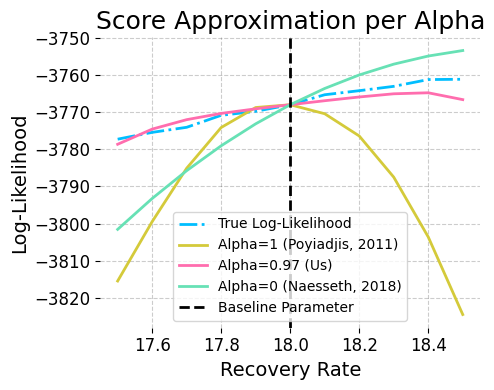

In [67]:
plt.figure(figsize=(5,4))
plt.plot(space, -onp.array(lls), linestyle='dashdot', label='True Log-Likelihood')
plt.plot(space, -onp.array(lls_mop_1), label='Alpha=1 (Poyiadjis, 2011)')
plt.plot(space, -onp.array(lls_mop_097), label='Alpha=0.97 (Us)')
plt.plot(space, -onp.array(lls_mop_0), label='Alpha=0 (Naesseth, 2018)')
#plt.xticks(rotation=45)
plt.locator_params(axis='x', nbins=10)
plt.xlabel('Recovery Rate')
plt.ylabel('Log-Likelihood')
plt.axvline(gam_phi, linestyle='--', color='black', label='Baseline Parameter')
plt.legend()
plt.title('Score Approximation per Alpha')
plt.tight_layout()
plt.savefig('imgs/095/mop.png', bbox_inches='tight')
#plt.show()

In [40]:
def resample_key(norm_weights, key):
    J = norm_weights.shape[-1]
    #counts = jax.random.categorical(key=jax.random.PRNGKey(randint), 
    #                   logits=jax.lax.stop_gradient(norm_weights),
    #                    shape=(J,))
    
    #unifs = 0.5+np.linspace(0,1,J)
    #unifs = np.where(unifs>=1, x=unifs-1, y=unifs) #when true x, else y
    
    #ARCHIVE
    #unifs = unifs.at[unifs>=1].set(unifs[unifs>=1]-1)
    
    unifs = (jax.random.uniform(key=key)+np.arange(J)) / J
    
    csum = np.cumsum(np.exp(norm_weights))
    counts = np.repeat(np.arange(J), 
                       np.histogram(unifs, 
                        bins=np.pad(csum/csum[-1], pad_width=(1,0)), 
                            density=False)[0].astype(int),
                      total_repeat_length=J)
    
    #if len(counts)<J:
    #    counts = np.hstack([counts, np.zeros(J-len(counts))]).astype(int)
    return counts

def resampler_key(counts, particlesP, norm_weights, key):
    J = norm_weights.shape[-1]
    counts = resample_key(norm_weights, key)
    particlesF = particlesP[counts]
    norm_weights = norm_weights[counts] - jax.lax.stop_gradient(norm_weights[counts]) - np.log(J)
    return counts, particlesF, norm_weights

def pfilter_debug(theta, ys, J, covars=None, thresh=-1, key=jax.random.PRNGKey(0)):
    
    particlesF = rinit(theta, J, covars=covars)
    particles = np.zeros((len(ys)+1, J, particlesF.shape[-1]))
    particles = particles.at[0].set(particlesF)
    meas_particles = np.zeros((len(ys), J))
    weights = np.log(np.ones(J)/J)
    norm_weights = np.log(np.ones(J)/J)
    counts = np.ones(J).astype(int)
    loglik = 0
    
    for t in tqdm(range(len(ys))):
        key, *keys = jax.random.split(key, num=J+1)
        keys = np.array(keys)
        

        # Get prediction particles 
        particlesP = rprocess(particlesF, theta, keys, covars)# if t>0 else particlesF

        measurements = dmeasure(ys[t], particlesP, theta)

        # Multiply weights by measurement model result
        weights = norm_weights + measurements

        # Obtain normalized weights
        norm_weights, loglik_t = normalize_weights(weights)
        loglik += loglik_t
        
        print(norm_weights)

        meas_particles = meas_particles.at[t].set(measurements)

        counts, particlesF, norm_weights = resampler_key(counts, particlesP, norm_weights, key)
        print(particlesP[counts].mean(0))
        print(particlesF.mean(0))

        #jax.debug.print(loglik, loglik_t)
        particles = particles.at[t+1].set(particlesF)
        
    return -loglik, particles, meas_particles


    
# test on linear gaussian toy model again
#@partial(jit, static_argnums=2)
def mop_debug(theta, ys, J, meas_phi, covars=None, alpha=0.97, key=jax.random.PRNGKey(0)):
    
    particlesF = rinit(theta, J, covars=covars)
    
    particles = np.zeros((len(ys)+1, J, particlesF.shape[-1]))
    particles = particles.at[0].set(particlesF)
    
    weights = np.log(np.ones(J)/J)
    weightsF = np.log(np.ones(J)/J)
    counts = np.ones(J).astype(int)
    loglik = 0
    
    for t in tqdm(range(len(ys))):
        key, *keys = jax.random.split(key, num=J+1)
        keys = np.array(keys)
        

        # Discount weights by alpha in logspace
        weightsP = alpha*weightsF

        # Get prediction particles 
        particlesP = rprocess(particlesF, theta, keys, covars)# if t>0 else particlesF

        measurements = dmeasure(ys[t], particlesP, theta)

        # Using before-resampling conditional likelihood
        loglik += (jax.scipy.special.logsumexp(weightsP + measurements) 
                   - jax.scipy.special.logsumexp(weightsP))

        # Obtain normalized measurement likelihoods for resampling
        norm_weights, loglik_phi_t = normalize_weights(jax.lax.stop_gradient(meas_phi[t]))

        # Systematic resampling according to normalized measurement likelihoods
        counts, particlesF, norm_weightsF = resampler_key(counts, particlesP, norm_weights, key)
        print(particlesP[counts].mean(0))
        print(particlesF.mean(0))

        # Correct for theta/phi and resample
        weightsF = (weightsP + measurements - jax.lax.stop_gradient(meas_phi[t]))[counts]

        particles = particles.at[t+1].set(particlesF)
        
    return -loglik, particles